### Импорты

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [97]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display

from sklearn import metrics

In [52]:
from sklearn.cluster import KMeans

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [159]:
from treeinterpreter import treeinterpreter as ti

### Загрузка данных

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [122]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

загружаем данные из таблицы

In [14]:
credits = pd.read_csv('Lab3/credit-default.csv')

#### Краткаое описание данных

In [15]:
display_all(credits.head())

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,4,real estate,67,none,own,2,1,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,2,real estate,22,none,own,1,2,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,3,real estate,49,none,own,1,1,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,4,building society savings,45,none,for free,1,1,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,4,unknown/none,53,none,for free,2,2,2,none,yes,skilled employee


Набор данных состоит из 1000 примеров. Зависимая переменная `default`, она предсталена целочисленными значениями, где 1 - возврат кредита, а 2 - это невозврат кредита. Набор признаков состоит из различных типов переменных. 

Категориальные признаки:
- `checking_balance` - баланс счета, который по существу является поделенной на интервалы числовой переменной
- `credit_history` - кредитная история
- `purpose` - назначение кредита
- `savings_balance` - баланс сбережений
- `employment_length` - рабочий стаж
- `personal_status` - семейное положение 
- `property` - наличие собсвенности
- и пр.

In [16]:
credits.checking_balance.value_counts()

unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64

In [17]:
credits.credit_history.value_counts()

repaid                    530
critical                  293
delayed                    88
fully repaid this bank     49
fully repaid               40
Name: credit_history, dtype: int64

In [18]:
credits.purpose.value_counts()

radio/tv               280
car (new)              234
furniture              181
car (used)             103
business                97
education               50
repairs                 22
domestic appliances     12
others                  12
retraining               9
Name: purpose, dtype: int64

In [19]:
credits.savings_balance.value_counts()

< 100 DM         603
unknown          183
101 - 500 DM     103
501 - 1000 DM     63
> 1000 DM         48
Name: savings_balance, dtype: int64

In [20]:
credits.employment_length.value_counts()

1 - 4 yrs     339
> 7 yrs       253
4 - 7 yrs     174
0 - 1 yrs     172
unemployed     62
Name: employment_length, dtype: int64

In [21]:
credits.personal_status.value_counts()

single male      548
female           310
married male      92
divorced male     50
Name: personal_status, dtype: int64

In [22]:
credits.property.value_counts()

other                       332
real estate                 282
building society savings    232
unknown/none                154
Name: property, dtype: int64

In [23]:
credits.describe()

,months_loan_duration,amount,installment_rate,residence_history,age,existing_credits,default,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.300000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.458487,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [24]:
# так как алгоритмы не принимают на вход
# строковых значений преобразуем их в категориальный
# тип данных
train_cats(credits)

In [25]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_balance        1000 non-null category
months_loan_duration    1000 non-null int64
credit_history          1000 non-null category
purpose                 1000 non-null category
amount                  1000 non-null int64
savings_balance         1000 non-null category
employment_length       1000 non-null category
installment_rate        1000 non-null int64
personal_status         1000 non-null category
other_debtors           1000 non-null category
residence_history       1000 non-null int64
property                1000 non-null category
age                     1000 non-null int64
installment_plan        1000 non-null category
housing                 1000 non-null category
existing_credits        1000 non-null int64
default                 1000 non-null int64
dependents              1000 non-null int64
telephone               1000 non-null category
foreign_worker          1

#### Предварительная обработка данных

Изменим зпнчения колонки `default` на стандартные 0 - отсутствие признака и 1 - присутстиве признака (дефолт по кредиту)

In [28]:
credits.loc[credits.default == 1, 'default'] = 0
credits.loc[credits.default == 2, 'default'] = 1

In [30]:
credits.default.mean()
# в данных 30% невыплат по кредиту

0.3

In [31]:
credits.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,0,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,1,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,0,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,0,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,1,2,none,yes,skilled employee


Окончательная предобработка данных сводится к тому, чтобы заменить категории в колонках
категориальных признаков, на коды этих категорий, они представлены числами и могут быть 
использованы в дальнейшей работе с алгоритмаим (самоорганизующиеся карты, случайный лес)

In [75]:
df, y, _ = proc_df(credits, 'default')

In [76]:
# теперь все данные представлены числовыми значениями
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,dependents,telephone,foreign_worker,job
0,2,6,1,8,1169,5,4,4,4,3,4,3,67,2,2,2,1,2,2,2
1,1,48,5,8,5951,3,2,2,2,3,2,3,22,2,2,1,1,1,2,2
2,4,12,1,5,2096,3,3,2,4,3,3,3,49,2,2,1,2,1,2,4
3,2,42,5,6,7882,3,3,2,4,2,4,1,45,2,1,1,2,1,2,2
4,2,24,2,2,4870,3,2,3,4,3,4,4,53,2,1,2,2,1,2,2


### Сегментация при алгоритма кластеризации KMeans

Проведём сегментацию заёмщиков по следующим входным параметрам:
- цель кредитования;
- сумма кредита;
- срок кредита;
- возраст;
- количество иждивенцев
- собственность
- стаж работы

In [77]:
use_columns = ['purpose', 'amount', 'months_loan_duration', 'age', 
               'dependents', 'property', 'employment_length']

# возмем только чать признаков
cluster_df = df[use_columns].copy()

In [88]:
# тренировака алгоритма
k_means = KMeans(n_clusters=3)
k_means.fit(cluster_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [89]:
# предскажем метку кластера для каждой записи
predict = k_means.predict(cluster_df)

In [90]:
cluster_df['cluster'] = predict

In [91]:
cluster_df.head()

,purpose,amount,months_loan_duration,age,dependents,property,employment_length,cluster
0,8,1169,6,67,1,3,4,1
1,8,5951,48,22,1,3,2,0
2,5,2096,12,49,2,3,3,1
3,6,7882,42,45,2,1,3,0
4,2,4870,24,53,2,4,2,0


In [96]:
# Сгруппируем по метке кластера и возьмем среднее по всем признакам
# попробуем увидеть разницу в кластерах
cluster_df.groupby('cluster').agg(['mean', 'std'])

purpose                  amount              months_loan_duration  \
             mean       std          mean          std                 mean   
cluster                                                                       
0        4.074074  2.534244   5742.245370  1409.657834            30.143519   
1        5.179945  2.729791   1890.082418   882.555974            16.718407   
2        3.910714  2.466332  11695.589286  2274.279536            39.660714   

                          age            dependents            property  \
               std       mean        std       mean       std      mean   
cluster                                                                   
0        12.606486  36.180556  11.263846   1.175926  0.381642  2.337963   
1         8.336400  35.318681  11.427185   1.148352  0.355693  2.329670   
2        13.268249  36.053571  11.219171   1.160714  0.370591  2.803571   

                  employment_length            
              std              mean       std  
cluster                                        
0        1.104597          2.824074  1.226291  
1        0.949103          2.641484  1.186482  
2        1.150804          2.875000  1.206987

In [93]:
credits.purpose.cat.categories

Index(['business', 'car (new)', 'car (used)', 'domestic appliances',
       'education', 'furniture', 'others', 'radio/tv', 'repairs',
       'retraining'],
      dtype='object')

### Дерево решений для объяснения результатов сегментации

In [99]:
X_clusters, y_clusters, _ = proc_df(cluster_df, 'cluster')

In [101]:
X_train, X_valid, y_train, y_valid = train_test_split(X_clusters, y_clusters, 
                                                      test_size=0.4, random_state=42)

In [116]:
tree = DecisionTreeClassifier(min_samples_split=50)

In [117]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

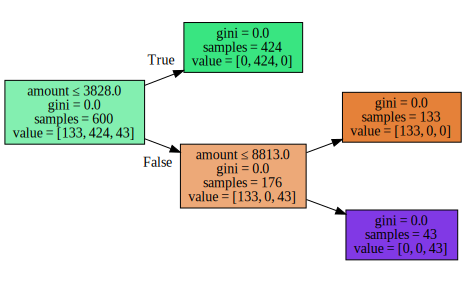

In [118]:
draw_tree(tree, X_clusters)

In [119]:
pred_y = tree.predict(X_valid)

In [123]:
cm = confusion_matrix(y_valid, pred_y)

Confusion matrix, without normalization
[[ 83   0   0]
 [  0 304   0]
 [  0   0  13]]


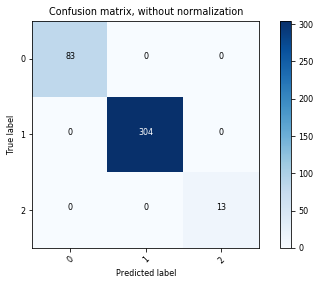

In [125]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

In [121]:
print(classification_report(y_valid, pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00       304
           2       1.00      1.00      1.00        13

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



### Построение многомерного отчёта и кросс-диаграммы выплачиваемых кредитов по возрастным группам

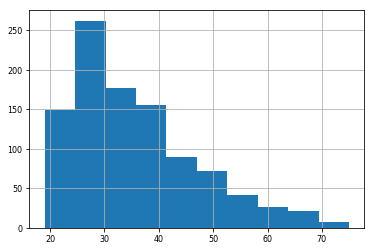

In [130]:
credits.age.hist()

Для этого выберем, только ту группу, которая выплатила кредиты, и покажем распределение возрастных групп

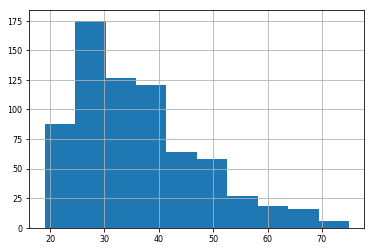

In [129]:
credits.loc[credits.default == 0, 'age'].hist()

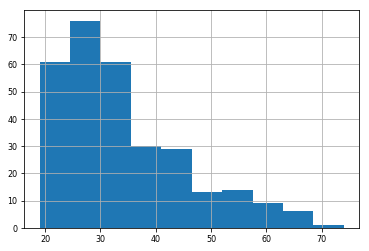

In [131]:
credits.loc[credits.default == 1, 'age'].hist()

### Построение модели дерева решений для оценки кредитоспособности заёмщика для сегмента №2

In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, 
                                                      test_size=0.2, random_state=42)

In [136]:
tree = DecisionTreeClassifier(min_samples_split=50)

In [137]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [138]:
tree = DecisionTreeClassifier(min_samples_split=50)

tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [144]:
tree.score(X_train, y_train)

0.79875

In [145]:
tree.score(X_valid, y_valid)

0.765

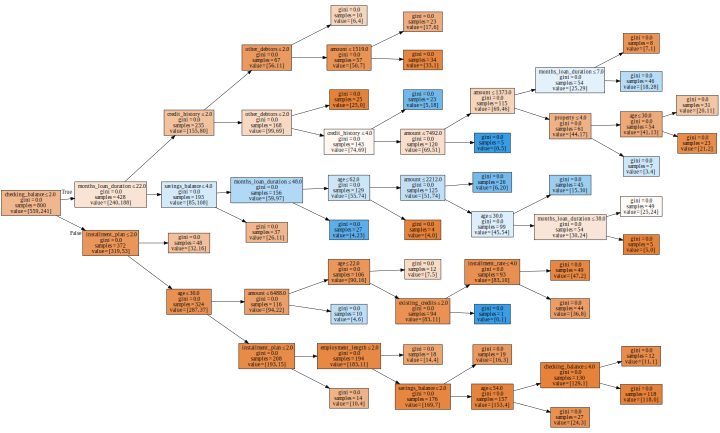

In [140]:
draw_tree(tree, df)

In [146]:
pred_y = tree.predict(X_valid)

In [147]:
cm = confusion_matrix(y_valid, pred_y)

Confusion matrix, without normalization
[[124  17]
 [ 30  29]]


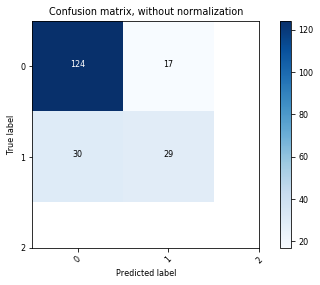

In [148]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

In [149]:
print(classification_report(y_valid, pred_y))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       141
           1       0.63      0.49      0.55        59

   micro avg       0.77      0.77      0.77       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.75      0.77      0.76       200



Важность признаков в полученном классификаторе

In [150]:
fi = rf_feat_importance(tree, df); fi[:10]

,cols,imp
0,checking_balance,0.294943
1,months_loan_duration,0.159171
4,amount,0.121389
12,age,0.096189
9,other_debtors,0.093955
2,credit_history,0.090125
5,savings_balance,0.057738
13,installment_plan,0.045107
15,existing_credits,0.013202
11,property,0.011353


In [151]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

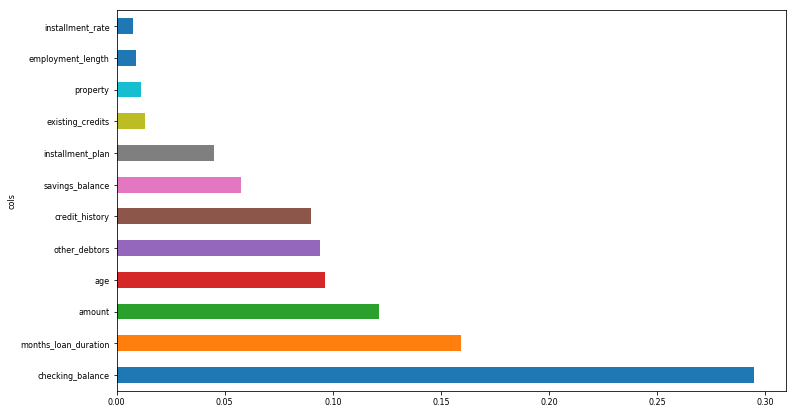

In [157]:
plot_fi(fi[:12]);

Проинтерпретируем процесс принятия решения нашей моделью для клиента из сегмента №2 "долгосрочный крупный кредит"
Для этого выберем один из примеров этого сегмента из нашего валидационного набора данных и применим к нему
функционал пакета `treeinterpreter`

In [163]:
X_valid.reset_index(inplace=True, drop=True)

In [164]:
X_valid[(X_valid.amount > 12000) & (X_valid.months_loan_duration > 40)]

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,dependents,telephone,foreign_worker,job
87,1,60,5,2,14027,3,3,4,4,3,2,4,27,2,2,1,1,2,2,1
98,1,48,3,1,14421,3,2,2,4,3,2,2,25,2,2,1,1,2,2,2


In [167]:
y_valid[87]

1

In [168]:
# Возьмем пример с индексом 87, его реальный результат - это невыплата кредита
# посмотрим, как будет принято решение деревом по этому случаю
row = X_valid.values[None,87]; row

array([[    1,    60,     5,     2, 14027,     3,     3,     4,     4,     3,     2,     4,    27,     2,
            2,     1,     1,     2,     2,     1]])

In [169]:
prediction, bias, contributions = ti.predict(tree, row)

In [211]:
prediction[0][1], bias[0][1]

(0.8518518518518519, 0.30125)

In [213]:
contributions[:,:,1][0]

array([0.14, 0.35, 0.  , 0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  ])

In [214]:
idxs = np.argsort(contributions[:,:,1][0])

In [215]:
[o for o in zip(X_valid.columns[idxs], X_valid.iloc[87][idxs], contributions[:,:,1][0][idxs])]

[('other_debtors', 3, 0.0),
 ('telephone', 2, 0.0),
 ('dependents', 1, 0.0),
 ('existing_credits', 1, 0.0),
 ('housing', 2, 0.0),
 ('installment_plan', 2, 0.0),
 ('age', 27, 0.0),
 ('property', 4, 0.0),
 ('residence_history', 2, 0.0),
 ('job', 1, 0.0),
 ('personal_status', 4, 0.0),
 ('installment_rate', 4, 0.0),
 ('employment_length', 3, 0.0),
 ('amount', 14027, 0.0),
 ('purpose', 2, 0.0),
 ('credit_history', 5, 0.0),
 ('foreign_worker', 2, 0.0),
 ('savings_balance', 3, 0.06220937956689254),
 ('checking_balance', 1, 0.1380023364485981),
 ('months_loan_duration', 60, 0.3503901358363612)]

In [216]:
contributions[:,:,1][0].sum()

0.5506018518518518

In [217]:
tree.predict_proba(X_valid.iloc[87].values.reshape(1, -1))

array([[0.15, 0.85]])

In [218]:
credits.checking_balance.cat.categories

Index(['1 - 200 DM', '< 0 DM', '> 200 DM', 'unknown'], dtype='object')

In [219]:
credits.savings_balance.cat.categories

Index(['101 - 500 DM', '501 - 1000 DM', '< 100 DM', '> 1000 DM', 'unknown'], dtype='object')